# Identify canidate causal genes for pQTLs

In [1]:
import pathlib
import pandas
import numpy

import hetmech.hetmat
import hetmech.pipeline

## Read pQTL associations and candidate genes

In [2]:
pqtl_df = pandas.read_table('pqtl.tsv')
loci_df = pandas.read_table('snps-to-locus-genes.tsv')
loci_df = loci_df.drop_duplicates()
snp_df = pqtl_df.merge(loci_df)
# Drop protein complexes
snp_df = snp_df.dropna(subset=['pqtl_entrez_id', 'locus_entrez_id'])
snp_df = snp_df[~snp_df.pqtl_entrez_id.str.contains(',')]
for col in 'pqtl_entrez_id', 'locus_entrez_id':
    snp_df[col] = snp_df[col].astype(int)
snp_df.head(2)

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp
0,rs651007,SELE,6401,102.728,23300549,ABO,28,3217
1,rs651007,SELE,6401,102.728,23300549,SURF6,6838,50343


In [3]:
gene_pairs = set(zip(snp_df.pqtl_entrez_id, snp_df.locus_entrez_id))
len(gene_pairs)

111716

## Extract permutation-adjusted DWPCs for relevant gene-gene pairs

In [4]:
hetmat = hetmech.hetmat.HetMat('../hetionet-v1.0.hetmat/')

In [25]:
metapaths = [
    'GpBPpGiG',
    #'GeAeG',
]

In [6]:
%%time
path = pathlib.Path('adjusted-dwpcs.tsv.gz')
if not path.exists():
    dwpc_rows = list()
    for metapath in metapaths:
        dwpc_generator = hetmech.pipeline.combine_dwpc_dgp(hetmat, metapath, damping=0.5)
        for row in dwpc_generator:
            if (row['source_id'], row['target_id']) in gene_pairs:
                row['metapath'] = metapath
                dwpc_rows.append(row)
    dwpc_df = pandas.DataFrame(dwpc_rows)
    dwpc_df.to_csv(path, index=False, sep='\t', compression='gzip')
dwpc_df = pandas.read_table(path)
dwpc_df.tail(2)

,source_id,target_id,source_name,target_name,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
74865,100507436,100507436,MICA,MICA,72,5,0,0.0,6411600,6406896,200,1.210616,0.573674,1.0,GpBPpGiG
74866,100507436,100507679,MICA,MUC22,72,0,0,0.0,45084000,0,200,NaN,NaN,1.0,GpBPpGiG


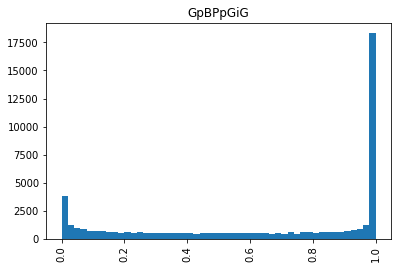

In [24]:
%matplotlib inline
dwpc_df.query("nnz > 0").hist(bins=50, column='p_value', by='metapath');

## Combine DWPC and pQTL information

In [8]:
snp_dwpc_df = (
    snp_df
    .merge(dwpc_df, left_on=['pqtl_entrez_id', 'locus_entrez_id'], right_on=['source_id', 'target_id'])
    .drop(columns=['source_id', 'target_id', 'source_name', 'target_name'])
)
snp_dwpc_df.head(2)

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
0,rs651007,SELE,6401,102.728,23300549,ABO,28,3217,64,2,1,0.365962,16671200,16015787,200,0.70011,0.585244,0.632176,GpBPpGiG
1,rs651007,SELE,6401,107.143,10.1101/086793,ABO,28,3217,64,2,1,0.365962,16671200,16015787,200,0.70011,0.585244,0.632176,GpBPpGiG


In [9]:
snp_dwpc_df.to_csv('candidates.tsv', index=False, sep='\t')

## Potential candidates of interest

In [14]:
groups = snp_dwpc_df.groupby(['gwas_source', 'snp', 'pqtl_gene'])
groups = [df.sort_values('p_value') for i, df in groups]

In [15]:
groups[2]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
64150,rs10127775,MAP2K4,6416,13.165,10.1101/086793,GALNT2,2590,102052,58,4,90,3.077606,14578000,14516202,200,0.992799,0.590786,0.005898,GpBPpGiG
64176,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ARV1,64801,818939,58,1,45,1.002571,36748400,31504598,200,0.401718,0.489000,0.088133,GpBPpGiG
64164,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ABCB10,23456,601347,58,1,45,1.002571,36748400,31504598,200,0.401718,0.489000,0.088133,GpBPpGiG
64168,rs10127775,MAP2K4,6416,13.165,10.1101/086793,C1orf198,84886,677077,58,1,45,1.002571,36748400,31504598,200,0.401718,0.489000,0.088133,GpBPpGiG
64172,rs10127775,MAP2K4,6416,13.165,10.1101/086793,TTC13,79573,746201,58,2,15,1.269866,23724400,22677352,200,0.672460,0.579313,0.129698,GpBPpGiG
64178,rs10127775,MAP2K4,6416,13.165,10.1101/086793,RAB4A,5867,854148,58,37,172,2.327298,947200,947200,200,2.260153,0.328263,0.400956,GpBPpGiG
64156,rs10127775,MAP2K4,6416,13.165,10.1101/086793,URB2,9816,499843,58,4,49,0.852308,14578000,14516202,200,0.992799,0.590786,0.516928,GpBPpGiG
64160,rs10127775,MAP2K4,6416,13.165,10.1101/086793,AGT,183,542481,58,19,49,1.787627,2516000,2516000,200,1.880289,0.417752,0.560056,GpBPpGiG
64170,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ACTA1,58,725944,58,140,590,2.956729,74000,74000,200,3.009042,0.192636,0.599395,GpBPpGiG
64166,rs10127775,MAP2K4,6416,13.165,10.1101/086793,NUP133,55746,651701,58,16,58,0.873330,3093200,3092800,200,1.781136,0.441551,0.993365,GpBPpGiG


In [16]:
groups[7]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
79435,rs10494745,HPX,3263,66.571,10.1101/086793,CFH,3075,170823,79,18,108,3.687287,1178000,1177800,200,2.007228,0.397697,0.000253,GpBPpGiG
79430,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR5,81494,59229,79,1,23,4.141619,15394600,13574476,200,0.452063,0.511281,0.000365,GpBPpGiG
79433,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR3,10878,122921,79,2,24,3.803143,9938600,9638663,200,0.761329,0.597103,0.001280,GpBPpGiG
79428,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR4,10877,645,79,3,30,3.611719,7830600,7770566,200,0.964608,0.603812,0.001982,GpBPpGiG
79431,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR1,3078,86138,79,4,28,2.768193,6107000,6095144,200,1.121360,0.591223,0.014682,GpBPpGiG
79429,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR2,3080,25445,79,1,14,0.469645,15394600,13574476,200,0.452063,0.511281,0.299099,GpBPpGiG
79436,rs10494745,HPX,3263,66.571,10.1101/086793,ZBTB41,360023,235353,79,1,16,0.155089,15394600,13574476,200,0.452063,0.511281,0.578460,GpBPpGiG
79432,rs10494745,HPX,3263,66.571,10.1101/086793,F13B,2165,120864,79,2,2,0.254531,9938600,9638663,200,0.761329,0.597103,0.791731,GpBPpGiG
79438,rs10494745,HPX,3263,66.571,10.1101/086793,CRB1,23418,349877,79,7,18,0.700144,3552600,3552477,200,1.450011,0.535343,0.948347,GpBPpGiG
79441,rs10494745,HPX,3263,66.571,10.1101/086793,LHX9,56956,993575,79,5,3,0.092428,5096400,5093314,200,1.251783,0.573022,0.999331,GpBPpGiG


In [17]:
groups[8]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
56895,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR5,81494,267231,21,1,21,4.667195,116204400,86925262,200,0.273747,0.431237,0.000104,GpBPpGiG
56885,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR3,10878,64470,21,2,21,4.320710,75020400,65062638,200,0.449195,0.527825,0.000367,GpBPpGiG
56891,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR4,10877,139916,21,3,27,4.141113,59108400,55000247,200,0.558740,0.555346,0.000531,GpBPpGiG
56897,rs10737680,CFH,3075,35.89,10.1101/086793,F13B,2165,328866,21,2,3,2.218504,75020400,65062638,200,0.449195,0.527825,0.012727,GpBPpGiG
56889,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR1,3078,109432,21,4,16,1.846759,46098000,44387506,200,0.647093,0.568289,0.041769,GpBPpGiG
56893,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR2,3080,233447,21,1,2,0.170845,116204400,86925262,200,0.273747,0.431237,0.297061,GpBPpGiG
56901,rs10737680,CFH,3075,35.89,10.1101/086793,ZBTB41,360023,443355,21,1,6,0.072647,116204400,86925262,200,0.273747,0.431237,0.415687,GpBPpGiG
56903,rs10737680,CFH,3075,35.89,10.1101/086793,CRB1,23418,557879,21,7,6,0.409454,26816400,26650110,200,0.860010,0.576097,0.768609,GpBPpGiG
56899,rs10737680,CFH,3075,35.89,10.1101/086793,ASPM,259266,373803,21,12,16,0.344700,13993200,13987922,200,1.114271,0.554812,0.963254,GpBPpGiG
56883,rs10737680,CFH,3075,35.89,10.1101/086793,CFH,3075,37179,21,18,0,0.000000,8892000,8891250,200,1.323567,0.520670,1.000000,GpBPpGiG


## Cypher queries

Use at https://neo4j.het.io.

### GpBPpGiG

```cypher
MATCH path = (n0:Gene)-[:PARTICIPATES_GpBP]-(n1)-[:PARTICIPATES_GpBP]-(n2)-[:INTERACTS_GiG]-(n3:Gene)
WHERE n0.name = 'MAP2K4'
  AND n3.name = 'GALNT2'
AND n0 <> n2 AND n0 <> n3 AND n2 <> n3
WITH [
  size((n0)-[:PARTICIPATES_GpBP]-()),
  size(()-[:PARTICIPATES_GpBP]-(n1)),
  size((n1)-[:PARTICIPATES_GpBP]-()),
  size(()-[:PARTICIPATES_GpBP]-(n2)),
  size((n2)-[:INTERACTS_GiG]-()),
  size(()-[:INTERACTS_GiG]-(n3))
] AS degrees, path
RETURN
  path,
  substring(reduce(string = '', node IN nodes(path) | string + '—' + node.name), 1) AS nodes,
  reduce(pdp = 1.0, d in degrees | pdp * d ^ -0.5) AS pdp
ORDER BY pdp DESC
LIMIT 10
```

### GeAeG

```cypher
MATCH path = (n0:Gene)-[:EXPRESSES_AeG]-(n1)-[:EXPRESSES_AeG]-(n2:Gene)
USING JOIN ON n1
WHERE n0.name = 'MAP2K4'
  AND n2.name = 'GALNT2'
  AND n0 <> n2
WITH [
  size((n0)-[:EXPRESSES_AeG]-()),
  size(()-[:EXPRESSES_AeG]-(n1)),
  size((n1)-[:EXPRESSES_AeG]-()),
  size(()-[:EXPRESSES_AeG]-(n2))
] AS degrees, path
RETURN
  path,
  substring(reduce(string = '', node IN nodes(path) | string + '—' + node.name), 1) AS nodes,
  reduce(pdp = 1.0, d in degrees | pdp * d ^ -0.5) AS pdp
ORDER BY pdp DESC
LIMIT 10
```

### Method

To create DWPC queries, you can use the following method:

```python
metapath = hetmat.metagraph.get_metapath('GpBPpGiG')
query = hetio.neo4j.construct_dwpc_query(metapath)
print(query)
```